# Notebook para a análise de dados

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas import DataFrame
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [112]:
data = pd.read_csv('./data/CAERS_ASCII_2004_2017Q2.csv')

In [113]:
#Conta e tenta limpar duplicadas
print('Temos',data.count()[1], 'registros')

data = data.drop_duplicates() #Drop rows which all columns are repeated

print('Agora temos',data.count()[1], 'registros')
print('A mesma quantidade!! Não existem linhas idênticas!!')


Temos 90786 registros
Agora temos 90786 registros
A mesma quantidade!! Não existem linhas idênticas!!


In [114]:
#Renomeia colunas
data = data.rename(index=str, columns={"RA_Report #": "Report ID",
                                "RA_CAERS Created Date": "Created Date",
                                "AEC_Event Start Date": "Start Date",
                                "PRI_Product Role": "Product Role",
                                "PRI_Reported Brand/Product Name": "Brand/Product Name",
                                "PRI_FDA Industry Code": "Industry Code",
                                "PRI_FDA Industry Name":"Industry Name",
                                "CI_Age at Adverse Event":"Age",
                                "CI_Age Unit":"Age Unit",
                                "CI_Gender":"Gender",
                                "AEC_One Row Outcomes":"One Row Outcomes",
                                "SYM_One Row Coded Symptoms":"One Row Coded Symptoms"
                               })
#Arruma as strins para datas
data['Created Date'] = pd.to_datetime(data['Created Date'], format='%m/%d/%Y')
data['Start Date'] = pd.to_datetime(data['Start Date'], format='%m/%d/%Y')

In [115]:
#Trata a idade colocando em dias e adiciona uma nova coluna
print('Unidade de medidas da idade:',np.unique(data['Age Unit']))

def transform_age_to_days(data_):
  age = []
  for index, row in data_.iterrows():
    value = row['Age']
    unit = row['Age Unit'] 
    if unit == 'Day(s)':
      age.append(value)
    elif unit == 'Week(s)':
      age.append(value*7)
    elif unit == 'Month(s)':
      age.append(value*30)
    elif unit == 'Year(s)':
      age.append(value*365)
    elif unit == 'Decades(s)':
      age.append(value*10*365)
    else:
      age.append(0.0)
  return age

data['Age in days'] = transform_age_to_days(data)

Unidade de medidas da idade: ['Day(s)' 'Decade(s)' 'Month(s)' 'Not Available' 'Week(s)' 'Year(s)']


In [116]:
#Adiciona uma colune para um intervalo na qual a data do consumidor esta
def apply_range_date(data_):
  age = []
  for index, row in data_.iterrows():
    value = row['Age in days'] / 365
    if value == 0: #for NotAvailable fields
      age.append('NA')
    elif value > 0 and value <= 10:
      age.append('1-10')
    elif value > 10 and value <= 20:
      age.append('11-20')
    elif value > 20 and value <= 30:
      age.append('21-30')
    elif value > 30 and value <= 40:
      age.append('31-40')
    elif value > 40 and value <= 50:
      age.append('41-50')
    elif value > 50 and value <= 60:
      age.append('51-60')
    elif value > 60 and value <= 70:
      age.append('61-70')
    elif value > 70 and value <= 80:
      age.append('71-80')
    elif value > 80 and value <= 90:
      age.append('81-90')
    elif value > 90 :
      age.append('91+')
  return age
      
data['Age Range'] = apply_range_date(data)

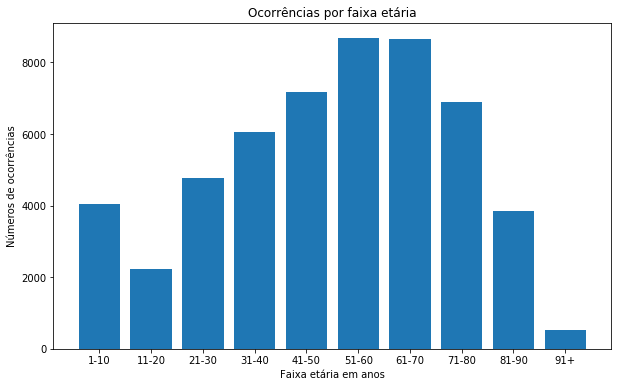

37895 sem informação de idade.


In [125]:
#histograma com o range de idade dos pacientes
labels, counts = np.unique(data[data['Age Range'] != 'NA']['Age Range'], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.rcParams["figure.figsize"] = [10,6]
plt.title('Ocorrências por faixa etária')
plt.ylabel('Números de ocorrências')
plt.xlabel('Faixa etária em anos')
plt.show()

labels_NA, counts_NA = np.unique(data[data['Age Range'] == 'NA']['Age Range'], return_counts=True)
print(counts_NA[0],'sem informação de idade.')

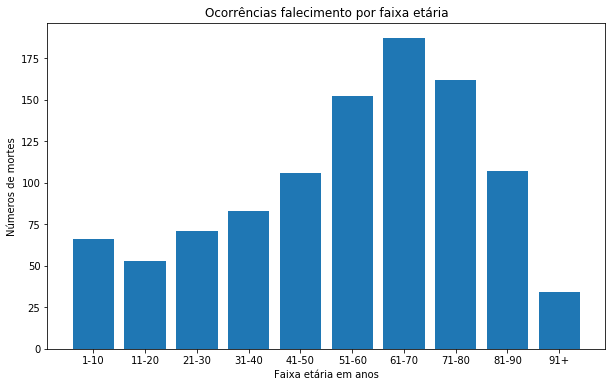

In [118]:
#histograma com o range de idade dos pacientes que vieram a falecer
labels, counts = np.unique(data[(data['One Row Outcomes'].str.contains('DEATH')) & (data['Age Range'] != 'NA')]['Age Range'], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.rcParams["figure.figsize"] = [10,6]
plt.title('Ocorrências falecimento por faixa etária')
plt.ylabel('Números de mortes')
plt.xlabel('Faixa etária em anos')
plt.show()

Temos 12 diferentes resultados
    Count                                   Outcomes
7   36837   OTHER SERIOUS (IMPORTANT MEDICAL EVENTS)
5   27835              NON-SERIOUS INJURIES/ ILLNESS
10  20158             VISITED A HEALTH CARE PROVIDER
3   16908                            HOSPITALIZATION
11  12890                              VISITED AN ER
4    5274                           LIFE THREATENING
9    3606                  SERIOUS INJURIES/ ILLNESS
8    2944  REQ. INTERVENTION TO PRVNT PERM. IMPRMNT.
2    2890                                 DISABILITY
1    2028                                      DEATH
6     145                                       NONE
0      77                         CONGENITAL ANOMALY


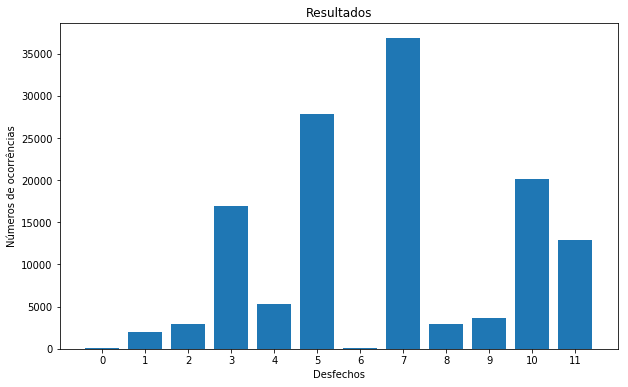

In [74]:
#Resultados dos relatos
#Diferentes tipos de resultados
array_all_outcomess = np.concatenate( [outcome.split(',') for outcome in data['One Row Outcomes']], axis=0 )
#Remove some spaces
array_all_outcomess,counts = np.unique([o.lstrip() for o in array_all_outcomess], return_counts=True)
ordered_outcomes_count = pd.DataFrame({'Outcomes': array_all_outcomess, 'Count': counts}).sort_values(by='Count', ascending=False)
print('Temos',len(array_all_outcomess), 'diferentes resultados')
print(ordered_outcomes_count)

#Histograma dos resultados
plt.bar(range(0,12), counts)
plt.gca().set_xticks([i for i,c in ordered_outcomes_count.iterrows()])
plt.rcParams["figure.figsize"] = [10,6]
plt.title('Resultados')
plt.ylabel('Números de ocorrências')
plt.xlabel('Desfechos')
plt.show()

Temos 4149 sintomas
      Count          Symptoms
1181  15542         DIARRHOEA
4085  13329          VOMITING
2630  11816            NAUSEA
13     9270    ABDOMINAL PAIN
2382   6497           MALAISE
897    5922           CHOKING
1269   5795          DYSPNOEA
1831   5708          HEADACHE
1981   5311  HYPERSENSITIVITY
1209   5109         DIZZINESS


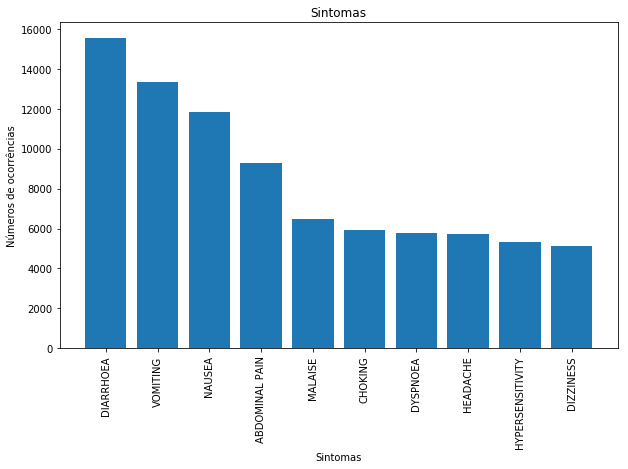

In [160]:
#Sintomas
#Diferentes tipos de sintomas
array_all_symptoms = np.concatenate( [str(symptom).split(',') for symptom in data['One Row Coded Symptoms']], axis=0 )
#Remove some spaces
array_all_symptoms, counts = np.unique([o.lstrip() for o in array_all_symptoms], return_counts=True)
ordered_symptoms_count = pd.DataFrame({'Symptoms': array_all_symptoms, 'Count': counts}).sort_values(by='Count', ascending=False)
print('Temos',len(array_all_symptoms), 'sintomas')
top = 10
print(ordered_symptoms_count[:top])

#Histograma dos resultados
plt.bar(ordered_symptoms_count['Symptoms'][:top], ordered_symptoms_count['Count'][:top])
plt.gca().set_xticks(ordered_symptoms_count['Symptoms'][:top])
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"] = [10,6]
plt.title('Sintomas')
plt.ylabel('Números de ocorrências')
plt.xlabel('Sintomas')
plt.show()

In [68]:
symptom = ordered_symptoms_count.reset_index(drop=True).at[0,'Symptoms']
print(symptom)
data_with_symptom = data[data['One Row Coded Symptoms'].str.contains(symptom, na=False)]
#rint(data_with_symptom)

array_products, counts = np.unique([o.lstrip() for o in data_with_symptom['Industry Name']], return_counts=True)
ordered_symptoms_count = pd.DataFrame({'Product': array_products, 'Count': counts}).sort_values(by='Count', ascending=False)

ordered_symptoms_count

DIARRHOEA


,Count,Product
37,3544,Vit/Min/Prot/Unconv Diet(Human/Animal)
36,1551,Vegetables/Vegetable Products
28,1526,Nuts/Edible Seed
15,1279,Fishery/Seafood Prod
2,922,Bakery Prod/Dough/Mix/Icing
19,896,Fruit/Fruit Prod
31,719,Soft Drink/Water
24,682,Milk/Butter/Dried Milk Prod
26,510,Mult Food Dinner/Grav/Sauce/Special
1,505,Baby Food Prod


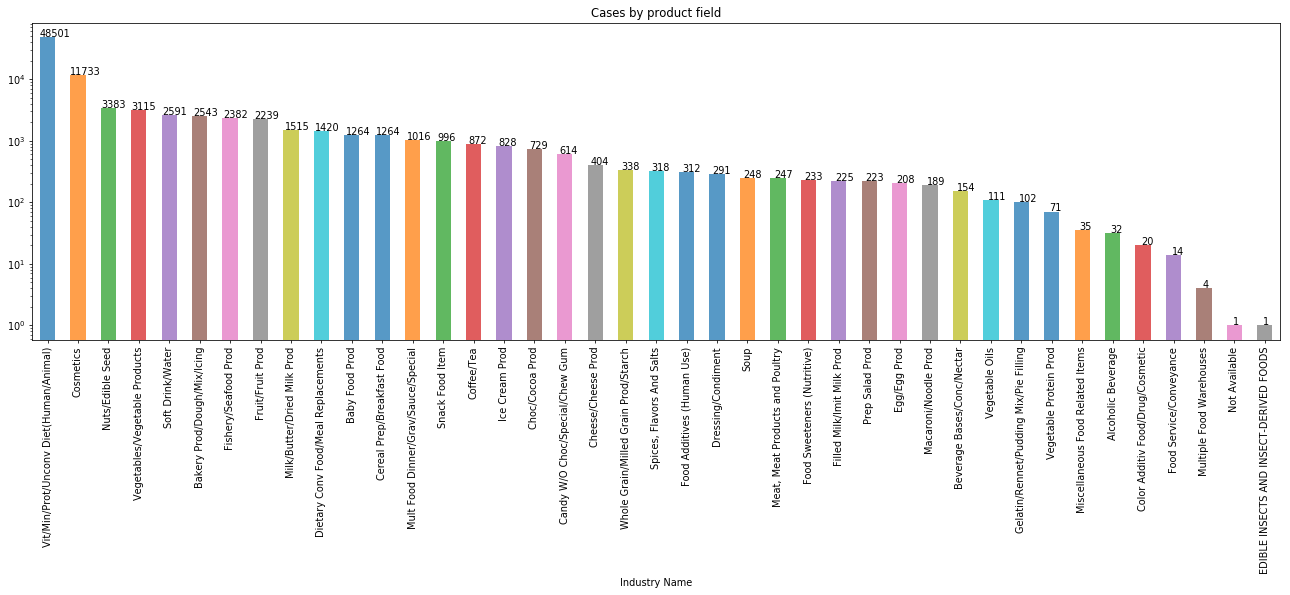

In [69]:
#Agrupa por tipo da industria, conta e ordenar de acordo com o número de casos em geral para cada segmento
count_by_field = data.groupby(['Industry Name']).count().sort_values(by='Report ID', ascending=False)

plt.figure(num=1, figsize=(23, 6), dpi=70, facecolor='w', edgecolor='k')

general_plot_bar = count_by_field.iloc[:,1].plot(kind='bar', logy='true',rot=90,alpha=0.75, title = 'Cases by product field')
#Insert the numbers on the bars
for p in general_plot_bar.patches:
    general_plot_bar.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

Existem 2028 mortes em 90786 itens. Representam 2.2338245985063776 por cento dos itens


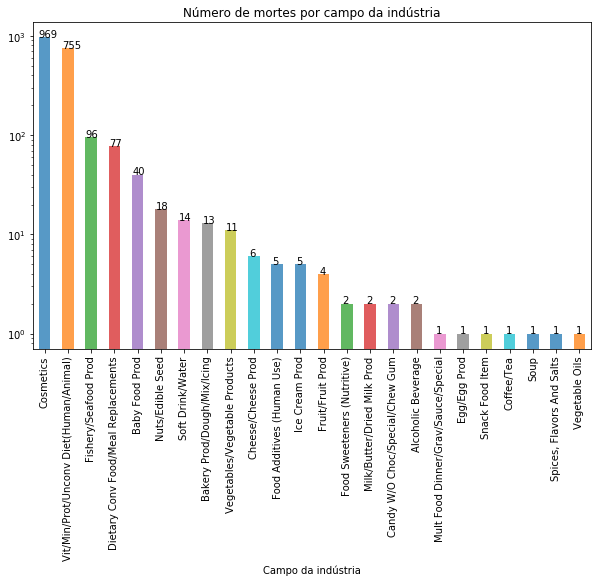

In [70]:
#Selecionando as linhas que resultaram em morte, pegamos os campos mais comuns
deathRowList = data.loc[data['One Row Outcomes'].str.contains('DEATH')]

numDeaths = len(deathRowList)
print('Existem', numDeaths, 'mortes em',len(data), 'itens. Representam',
      (numDeaths/len(data))*100, 'por cento dos itens')

#Agrupa por tipo da industria, conta e ordenar de acordo com o número de mortes para cada segmento
deatchCountByField = deathRowList.groupby(['Industry Name']).count().sort_values(by='Report ID', ascending=False)
plt.figure();
#print(deatchCountByFactory.iloc[:,1])
deathPlotBar = deatchCountByField.iloc[:,1].plot(kind='bar',logy='true',rot=90,alpha=0.75, 
                                                 title = 'Número de mortes por campo da indústria')
deathPlotBar.set_xlabel("Campo da indústria")
#Insert the numbers on the bars
for p in deathPlotBar.patches:
    deathPlotBar.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


In [71]:
#Célula somente para destacar o top 5 Industrias e no geral
unique, counts = np.unique(data["Industry Name"], return_counts=True)
sorted_industry_adverses = pd.DataFrame({'Industry Name': unique, 'Count': counts}).sort_values(by='Count', ascending=False)
print('Top 5 indústrias mais comuns') 
print(sorted_industry_adverses[0:5])

print('O campo da indústria mais comum é',sorted_industry_adverses.values[0][1])
data_most_common_only = data[data["Industry Name"]==sorted_industry_adverses.values[0][1]]

Top 5 indústrias mais comuns
    Count                           Industry Name
39  48501  Vit/Min/Prot/Unconv Diet(Human/Animal)
10  11733                               Cosmetics
30   3383                        Nuts/Edible Seed
38   3115           Vegetables/Vegetable Products
33   2591                        Soft Drink/Water
O campo da indústria mais comum é Vit/Min/Prot/Unconv Diet(Human/Animal)


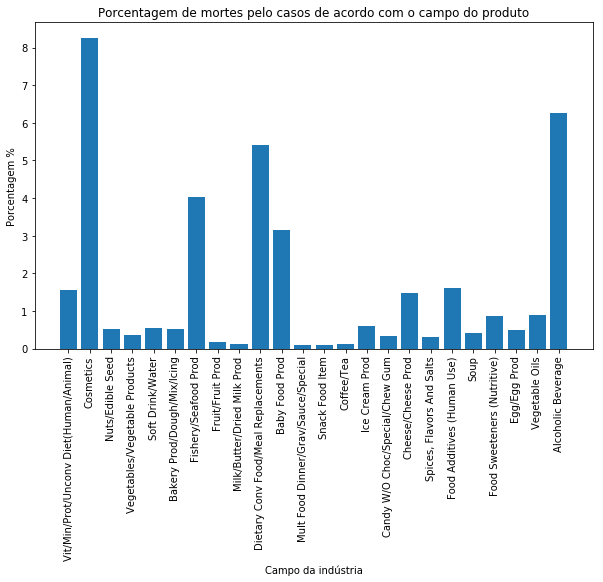

In [72]:
#Porcentagem de morte sobre numero de relatos por industria
arr_num = []
arr_str = []
for field in count_by_field['Report ID'].index:
    try:
        num_death = deatchCountByField['Report ID'][field]
        arr_num.append(100 * num_death/count_by_field['Report ID'][field])
        arr_str.append(field)
    except:
        pass
plt.bar(arr_str, arr_num)
plt.gca().set_xticks(arr_str)
plt.xticks(rotation=90)
plt.xlabel('Campo da indústria')
plt.ylabel('Porcentagem %')
plt.title('Porcentagem de mortes pelo casos de acordo com o campo do produto')
plt.show()

# Análise por gênero #

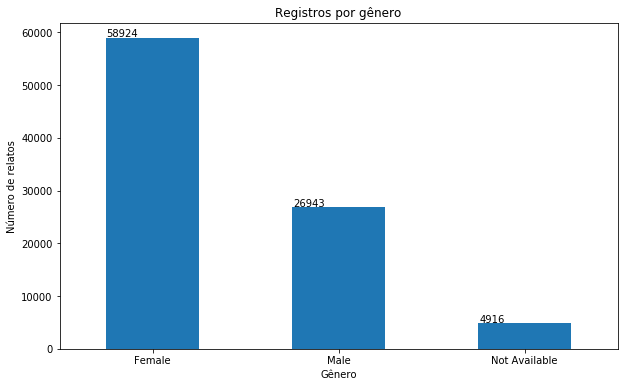

In [167]:
data_gender = DataFrame({'count' : data.groupby(['Gender']).size()}).reset_index()

plot_gender = data_gender[0:3].plot(kind='bar',legend=False)
plot_gender.set_xlabel("Gênero")
plot_gender.set_ylabel("Número de relatos")
plot_gender.set_title('Registros por gênero')
plot_gender.set_xticklabels(data_gender['Gender'], rotation=0)
for p in plot_gender.patches:
    plot_gender.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

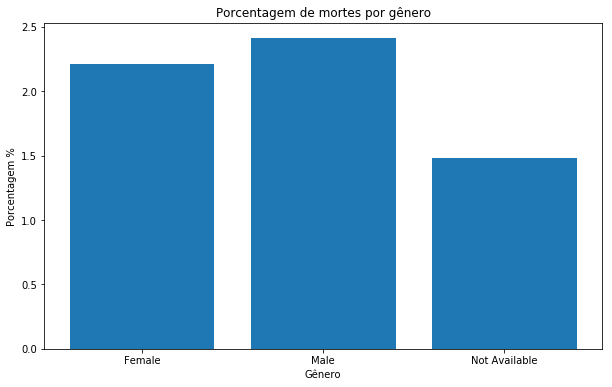

In [153]:
death_count_gender = deathRowList.groupby(['Gender']).count().sort_values(by='Report ID', ascending=False)
arr_num = []
arr_str = []
for field in data_gender['Gender'][:3]:
    try:
        num_death = death_count_gender['Report ID'][field]
        arr_num.append(100 * num_death/data_gender[data_gender_field['Gender']==field]['count'].item())
        arr_str.append(field)
    except:
        pass
plt.bar(arr_str, arr_num)
plt.gca().set_xticks(arr_str)
plt.xlabel('Gênero')
plt.ylabel('Porcentagem %')
plt.title('Porcentagem de mortes por gênero')
plt.show()